# Исследование надежности заемщиков

- Необходимо определить, влияют ли семейное положение, количество детей, уровень дохода клиента и цель кредита на факт погашения кредита в срок. Заказчик - банк, и ему важно иметь возможность до одобрения кредита предсказать вероятность возврата кредита в срок. Результат работы в этом проекте будет использован при построении модели кредитного скоринга.

- Входные данные: Датасет содержащий данные о возрасте клиента, стаже, семейном положении, образовании, доходе, цели кредита. Целевой признак - наличие задолженности по кредиту.

## Загрузка и оценка данных

Загрузим данные

In [1]:
import pandas as pd

try:
    data = pd.read_csv('/datasets/data.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/data.csv')

Выведем первые 20 строк

In [2]:
data.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


Выведем основную информацию о датафрейме

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


## Предобработка данных

### Обработка пропусков - 1

- Определим количество пропусков по столбцам

In [4]:
data.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

Пропуски в столбце `total_income` заменим медианным значением

In [5]:
for t in data['income_type'].unique():
    data.loc[(data['income_type'] == t) & (data['total_income'].isna()), 'total_income'] = \
    data.loc[(data['income_type'] == t), 'total_income'].median()

### Обработка аномальных значений

В столбце `days_employed` не может быть отрицательных значений - заменим их на положительные

In [6]:
data['days_employed'] = data['days_employed'].abs()

Проверим медианные значения по трудовому стажу

In [7]:
data.groupby('income_type')['days_employed'].agg('median')

income_type
безработный        366413.652744
в декрете            3296.759962
госслужащий          2689.368353
компаньон            1547.382223
пенсионер          365213.306266
предприниматель       520.848083
сотрудник            1574.202821
студент               578.751554
Name: days_employed, dtype: float64

Некоторые группы имеют аномально большие значения - пока оставим как есть

Посмотрим на значения в столбце `children`

In [8]:
data['children'].unique()

array([ 1,  0,  3,  2, -1,  4, 20,  5], dtype=int64)

Встречаются аномальные значения - удалим их

In [9]:
data = data[(data['children'] != -1) & (data['children'] != 20)]

Проверим что аномальные значения удалены

In [10]:
data['children'].unique()

array([1, 0, 3, 2, 4, 5], dtype=int64)

### Обработка пропусков - 2

Пропуски в столбце `days_employed` заполним медианными значениями по каждого типа занятости `income_type`

In [11]:
for t in data['income_type'].unique():
    data.loc[(data['income_type'] == t) & (data['days_employed'].isna()), 'days_employed'] = \
    data.loc[(data['income_type'] == t), 'days_employed'].median()

Еще раз проверим данные на пропуски

In [12]:
data.isna().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

### Изменение типов данных

Заменим вещественный тип данных в столбце `total_income` на целочисленный

In [13]:
data['total_income'] = data['total_income'].astype(int)

### Обработка дубликатов

Проверим количество дубликатов и удалим если они есть

In [14]:
data.duplicated().sum()

54

In [15]:
data = data.drop_duplicates()

Обработаем неявные дубликаты в столбце `education` по регистру

In [16]:
data['education'] = data['education'].str.lower()

### Категоризация данных

- Разделим клиентов на категории по доходам

In [17]:
def categorize_income(income):
    try:
        if 0 <= income <= 30000:
            return 'E'
        elif 30001 <= income <= 50000:
            return 'D'
        elif 50001 <= income <= 200000:
            return 'C'
        elif 200001 <= income <= 1000000:
            return 'B'
        elif income >= 1000001:
            return 'A'
    except:
        pass

In [18]:
data['total_income_category'] = data['total_income'].apply(categorize_income)

Посмотрим на уникальные цели кредита

In [19]:
data['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

Сгруппируем одинаковые цели кредита

In [20]:
def categorize_purpose(row):
    try:
        if 'автом' in row:
            return 'операции с автомобилем'
        elif 'жил' in row or 'недвиж' in row:
            return 'операции с недвижимостью'
        elif 'свад' in row:
            return 'проведение свадьбы'
        elif 'образов' in row:
            return 'получение образования'
    except:
        return 'нет категории'

In [21]:
data['purpose_category'] = data['purpose'].apply(categorize_purpose)


## Исследование данных

**Описание столбцов данных**\
children — количество детей в семье\
days_employed — общий трудовой стаж в днях\
dob_years — возраст клиента в годах\
education — уровень образования клиента\
education_id — идентификатор уровня образования\
family_status — семейное положение\
family_status_id — идентификатор семейного положения\
gender — пол клиента\
income_type — тип занятости\
debt — имел ли задолженность по возврату кредитов\
total_income — ежемесячный доход\
purpose — цель получения кредита

### Если ли зависимость между количеством детей и вероятностью просрочки?

,Children amount,Loaner,Latepay,Latepay ratio
0,0,14107,1063,0.075353
1,1,4809,444,0.092327
2,2,2052,194,0.094542
3,3,330,27,0.081818
4,4,41,4,0.097561
5,5,9,0,0.000000


0.017800262319655237


<AxesSubplot:xlabel='Children amount', ylabel='Latepay ratio'>

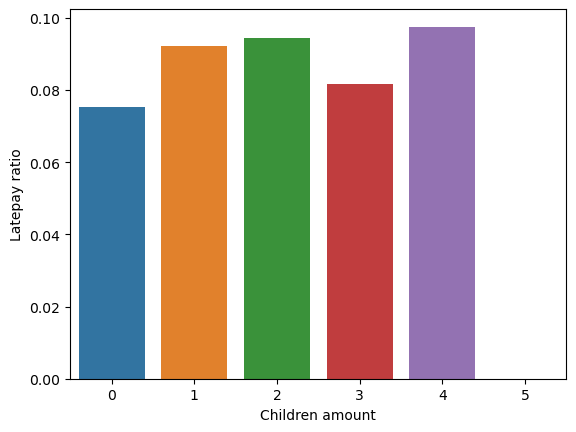

In [22]:
import seaborn as sns

#Отсортируем таблицу по числу детей у заемщика (0-5)
data=data.sort_values(by='children',ascending=True)

#Сделаем отдельный список на уникальные значения по количеству детей
children_groups=data['children'].unique()

# Посчитаем общее число заемщиков по группам
total_loaner_by_child_amount = list(data.groupby('children')['children'].count())

# Посчитаем общее число заемщиков с просрочкой по группам
total_latepayer_by_child_amount=list(data.groupby('children')['debt'].sum())

#Сделаем табличку с промежуточными данными. Child Latepay = cl
child_data={'Children amount':children_groups,'Loaner':total_loaner_by_child_amount,\
 'Latepay':total_latepayer_by_child_amount}
cl=pd.DataFrame(child_data)

#Добавим столбец с коэффициентом просрочки
cl['Latepay ratio']=(cl['Latepay']/cl['Loaner'])
display(cl)

# Виден рост вероятности просрочки в группах от 0 до 2 включительно, затем провал и опять рост. У заемщиков
# с 5 детьми вообще ни одной просрочки. 
# посчитаем долю заемщиков с количеством детей 3 и более

loaner_more_that_two=(data.loc[data['children']>=3,'children'].count())/data.shape[0]
print(loaner_more_that_two)

# таких заемщиков всего 1,7% в относительном выражении, в общем выводе ими можно пренебречь

display(sns.barplot(x = 'Children amount', y = 'Latepay ratio', data = cl))

**Выводы:**
1. С увеличением числа детей у заемщика вероятность просрочки кредита возрастает. Это справедливо для заемщиков с числом детей до 2 включительно.
2. Для заемщиков с числом детей 3 и более такой зависимости не наблюдается. Однако таких заемщиков всего 1,7% от общего числа. Если возможно, следует увеличить выборку

### Есть ли зависимость между семейным положением и возвратом кредита в срок

,Family status,Loaner,Latepay ratio
2,вдовец / вдова,951,0.066246
1,в разводе,1189,0.070648
4,женат / замужем,12266,0.075575
3,гражданский брак,4146,0.092861
0,Не женат / не замужем,2796,0.097639


<AxesSubplot:xlabel='Family status', ylabel='Latepay ratio'>

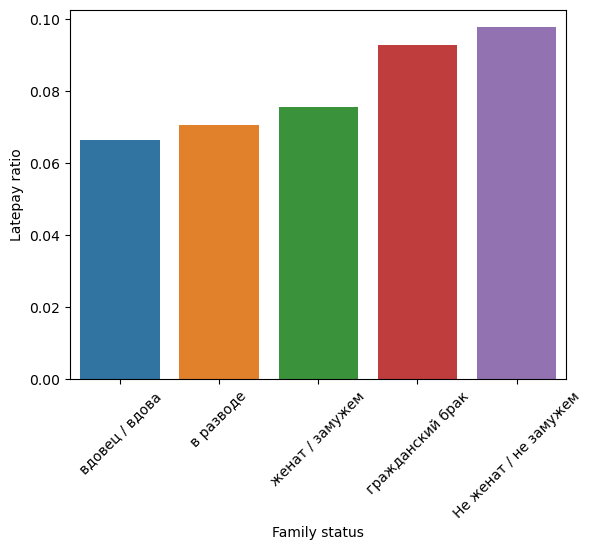

In [23]:
import matplotlib.pyplot as plt

# отсортируем таблицу по семейному статусу
data=data.sort_values(by='family_status',ascending=True)

# посчитаем число заемщиков по группам
family_status_groups=(data.groupby('family_status')['family_status_id'].count())
#print('Число заемщиков по группам\n',family_status_groups)

# посчитаем число заемщиков с просрочками по группам
family_status_groups_debt=(data.groupby('family_status')['debt'].sum())
#print('Число заемщиков с просрочкой\n',family_status_groups_debt)

# посчитаем коэффициент вероятности просрочки по группам
latepay_ratio_family=family_status_groups_debt/family_status_groups
#print(latepay_ratio_family)

# Переведем series в списки для таблицы
family_status_list=list(data['family_status'].unique())
family_status_id_list=list(data['family_status_id'].unique())
family_status_groups_list=list(family_status_groups)
latepay_ratio_list=list(latepay_ratio_family)

# Сделаем табличку с промежуточными результатами
latepay_family_data={'Family status':family_status_list,'Loaner':family_status_groups_list,\
'Latepay ratio':latepay_ratio_list}
fl=pd.DataFrame(latepay_family_data)

# отсортируем по коэффициенту просрочки
fl=fl.sort_values(by='Latepay ratio',ascending=True)
display(fl)

# Сдалем график 
fl = sns.barplot(x = 'Family status', y = 'Latepay ratio', data = fl)
fl.set_xticklabels(fl.get_xticklabels(),rotation = 45)
display(fl)

**Вывод:** 
1. Люди состоящие в официальном браке или когда либо бывшие в нем, с меньшей вероянтостью могут просрочить кредит

### Есть ли зависимость между уровнем дохода и возвратом кредита в срок?**

Максимальная вероятность просрочки в группе E (доход 0-30 тыс)
Минимальная вероятность просрочки в группе D (доход 30-50 тыс)


<AxesSubplot:xlabel='Income group', ylabel='Latepay ratio'>

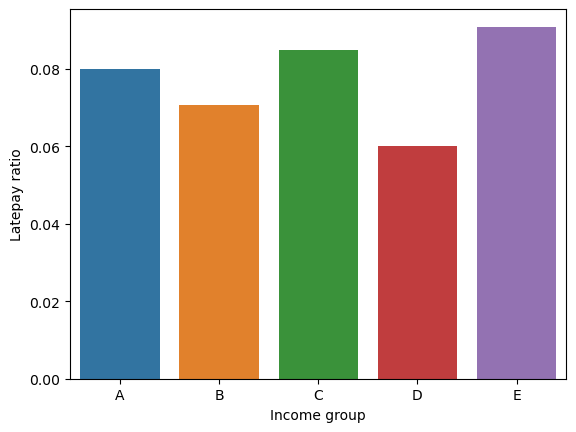

In [24]:
# отсортируем таблицу по категория дохода
data=data.sort_values(by='total_income_category',ascending=True)

# посчитаем число заемщиков по категориям дохода
income_groups_total=(data.groupby('total_income_category')['total_income_category'].count())
#print('Число заемщиков по группам\n',income_groups)

# посчитаем число заемщиков с просрочками по группам
income_groups_debt=(data.groupby('total_income_category')['debt'].sum())
#print('Число заемщиков с просрочкой\n',income_groups_debt)

# посчитаем коэффициент вероятности просрочки по группам
latepay_ratio_income=income_groups_debt/income_groups_total
#print(latepay_ratio_income)

# Переведем series в списки для таблицы
income_groups_list=list(data['total_income_category'].unique())
income_groups_total_list=list(income_groups_total)
latepay_ratio_income_list=list(latepay_ratio_income)

# Сделаем табличку с промежуточными результатами
latepay_income_data={'Income group':income_groups_list,\
'Loaner':income_groups_total_list,'Latepay ratio':latepay_ratio_income_list}
il=pd.DataFrame(latepay_income_data)

#отсортируем по группам дохода
il=il.sort_values(by='Income group',ascending=True)


# Посмотрим в каких группах максимальная и минимальная вероятность просрочки
print("Максимальная вероятность просрочки в группе",\
il.loc[il['Latepay ratio'] == il['Latepay ratio'].max(),'Income group'].to_string(index=False),'(доход 0-30 тыс)')
print('Минимальная вероятность просрочки в группе',\
il.loc[il['Latepay ratio'] == il['Latepay ratio'].min(),'Income group'].to_string(index=False),'(доход 30-50 тыс)')


# Сделаем график 
il = sns.barplot(x = 'Income group', y = 'Latepay ratio', data = il)
display(il)

**Вывод:** 
1. Вероятность просрочки в целом не зависит от дохода заемщика
2. Максимальная доля просрочек в группе E (0-30 тыс): 8,5%
3. Минимальная доля просрочек в группе D (30-50 тыс): 5,5%


### Как разные цели кредита влияют на его возврат в срок?

,Purpose,Loaner,Latepay ratio
1,операции с недвижимостью,10754,0.072531
3,проведение свадьбы,2324,0.078744
2,получение образования,3989,0.092504
0,операции с автомобилем,4281,0.093436


<AxesSubplot:xlabel='Purpose', ylabel='Latepay ratio'>

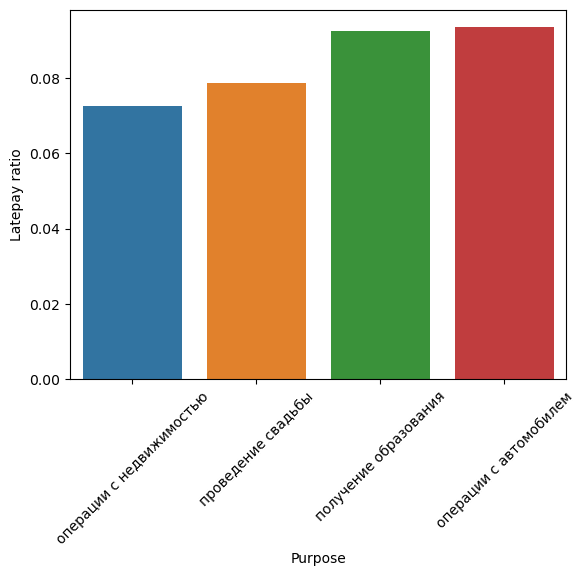

In [25]:
# отсортируем таблицу по категория дохода
data=data.sort_values(by='purpose_category',ascending=True)

# посчитаем число заемщиков по категориям дохода
purpose_groups_total=(data.groupby('purpose_category')['purpose_category'].count())
#print('Число заемщиков по группам\n',purpose_groups)

# посчитаем число заемщиков с просрочками по группам
purpose_groups_debt=(data.groupby('purpose_category')['debt'].sum())
#print('Число заемщиков с просрочкой\n',purpose_groups_debt)

# посчитаем коэффициент вероятности просрочки по группам
purpose_ratio=purpose_groups_debt/purpose_groups_total
#print(purpose_ratio)

# Переведем series в списки для таблицы
purpose_category_list=list(data['purpose_category'].unique())
purpose_groups_total_list=list(purpose_groups_total)
purpose_ratio_list=list(purpose_ratio)

# Сделаем табличку с промежуточными результатами
purpose_data={'Purpose':purpose_category_list,'Loaner':purpose_groups_total_list,\
'Latepay ratio':purpose_ratio_list}
pl=pd.DataFrame(purpose_data)

# отсортируем по вероятности просрочки
pl=pl.sort_values(by='Latepay ratio',ascending=True)
display(pl)

# Сделаем график 
pl = sns.barplot(x = 'Purpose', y = 'Latepay ratio', data = pl)
pl.set_xticklabels(pl.get_xticklabels(),rotation = 45)
display(pl)


**Вывод:** 
1. Операции с недвижимостью и проведение свадеб - наименее рискованные цели кредита с точки зрения вероятности просрочки
2. Вероятность просрочки кредита на получение образования и операции с автомобилем - примерно одинаковая

## Общий вывод

1. Исходные данные требуют предобработки - удаления пропусков, замены некорректных значений, категоризации
2. Наличие детей увеличивает вероятность просрочки
3. Вероятность просрочки не зависит от дохода заемщика
4. Ипотечные кредиты - самые надежные для банка
5. Никогда не состоявшие в браке или состоящие в неофициальном браке - менее надежные клиенты по сравнению с прочими